# 1. Descarga y exploración del corpus

> 1. Cardinalidad del vocabulario

> 2. Distibución de reviews por número de estrellas

> 3. Nº de reviews positivas y negativas

> 4. N-grams más frecuentes

> 5. Nubes de palabras

> 6. Visualización en 2D de algunos word embeddings

> 7. Conclusiones

Usaré los datos de Musical Instruments descargados de: http://jmcauley.ucsd.edu/data/amazon/

In [187]:
# Importar paquetes necesarios
import numpy as np
import pandas as pd
import os
from wordcloud import WordCloud

seed = 17

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
%matplotlib inline

from nltk import ngrams
from nltk.probability import FreqDist
from collections import Counter

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # Muestra todas las filas
pd.set_option('display.max_columns', None) # Muestra todas las columnas

In [188]:
# Datos descargados de http://jmcauley.ucsd.edu/data/amazon/
# ! unzip datasets.zip

import zipfile
with zipfile.ZipFile("datasets.zip", "r") as z:
    z.extractall(".")

In [189]:
datasets_path = 'datasets'
instruments_json = 'reviews_Musical_Instruments_5.json.gz'
df_instruments = pd.read_json(os.path.join(datasets_path, instruments_json), lines = True, compression = 'gzip')

In [190]:
df_instruments.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"


In [191]:
# Número de reviews
df_instruments.shape[0]

10261

In [192]:
# Subconjunto de características 'reviewText' y 'overall'
df_instruments = df_instruments[['reviewText', 'overall']]
df_instruments.head(3)

,reviewText,overall
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5


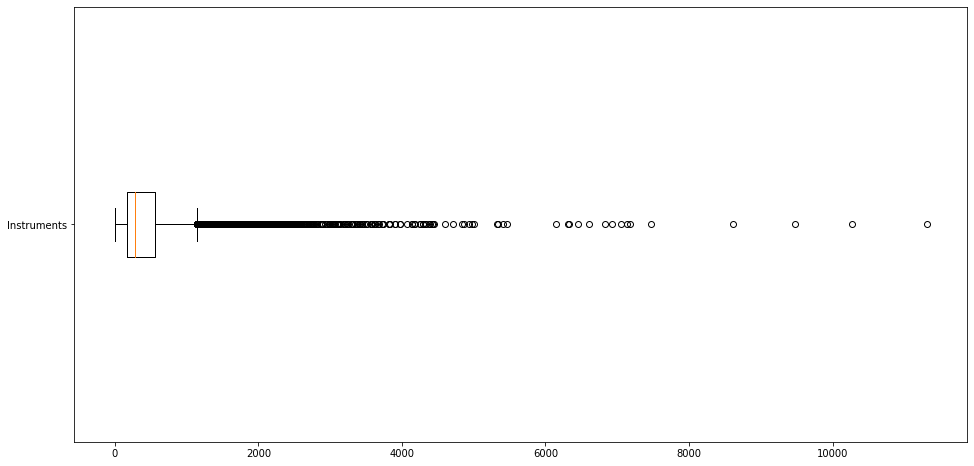

In [193]:
# Longitud de reviews
plt.figure(figsize = (16, 8))
plt.boxplot([[len(review) for review in df_instruments['reviewText']]], vert = False)
plt.yticks([1], ['Instruments'])

plt.show()

In [194]:
def get_vocabulary(df, col_name):

    words_ = []
    bigrams_ = []
    trigrams_ = []

    for review in df[col_name]:
        for word in review.split():
            words_.append(word)

    bigrams_ = list(ngrams(words_, 2))
    trigrams_ = list(ngrams(words_, 3))

    vocab = {
        'words': words_,
        'bigrams': bigrams_,
        'trigrams': trigrams_
    }

    return vocab

In [195]:
# Texto completo
inst_vocabulary = get_vocabulary(df_instruments, 'reviewText')

## 1. Cardinalidad del vocabulario

In [196]:
print('- Número de palabras totales en el vocabulario: ', str(len(inst_vocabulary['words'])))
print('- Número de palabras únicas en el vocabulario: ',  str(len(set(inst_vocabulary['words']))))

- Número de palabras totales en el vocabulario:  925371
- Número de palabras únicas en el vocabulario:  57714


## 2. Distibución de reviews por número de estrellas

<AxesSubplot:title={'center':'Overall ratings distribution'}>

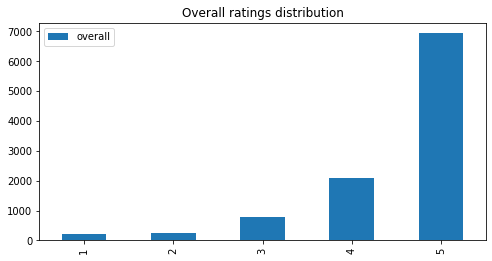

In [197]:
aux = pd.DataFrame(df_instruments['overall'].value_counts(sort = False).sort_index())
ax = aux.plot(kind='bar', title='Overall ratings distribution', figsize = (8, 4))

ax

## 3. Nº de reviews positivas y negativas

<AxesSubplot:title={'center':'Overall sentiment distribution'}>

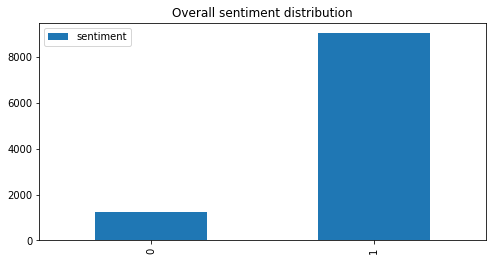

In [198]:
# Personalmente creo que 3 es una review negativa
df_instruments.loc[:, 'sentiment'] = [0 if overall <= 3 else 1 for overall in df_instruments['overall']]
aux = pd.DataFrame(df_instruments['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind = 'bar', title = 'Overall sentiment distribution', figsize = (8, 4))

ax

## 4. N-grams más frecuentes

In [199]:
# Las 20 palabras más comunes
wf = Counter(inst_vocabulary['words'])
wf_most_common = wf.most_common(20)

wf_most_common

[('the', 39202),
 ('a', 27174),
 ('and', 26137),
 ('I', 25313),
 ('to', 22619),
 ('it', 14969),
 ('is', 14238),
 ('of', 13434),
 ('for', 12249),
 ('this', 9317),
 ('with', 8744),
 ('my', 8738),
 ('on', 8554),
 ('that', 8543),
 ('in', 8117),
 ('you', 7911),
 ('have', 6913),
 ('but', 6831),
 ('are', 5667),
 ('as', 5150)]

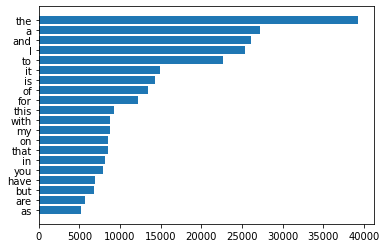

In [200]:
# Gráfico de las 20 palabras más comunes
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)

plt.show()

In [201]:
# Los 20 bigramas más comunes
bg_freq = Counter(inst_vocabulary['bigrams'])
bg_freq_most_common = bg_freq.most_common(20)

bg_freq_most_common

[(('of', 'the'), 3129),
 (('I', 'have'), 2453),
 (('on', 'the'), 2341),
 (('is', 'a'), 2189),
 (('in', 'the'), 1787),
 (('for', 'the'), 1713),
 (('and', 'the'), 1704),
 (('with', 'the'), 1619),
 (('for', 'a'), 1567),
 (('to', 'the'), 1561),
 (('it', 'is'), 1361),
 (('and', 'I'), 1308),
 (('and', 'it'), 1292),
 (('with', 'a'), 1291),
 (('if', 'you'), 1184),
 (('to', 'be'), 1170),
 (('on', 'my'), 1143),
 (('have', 'a'), 1140),
 (('a', 'little'), 1118),
 (('I', 'was'), 1060)]

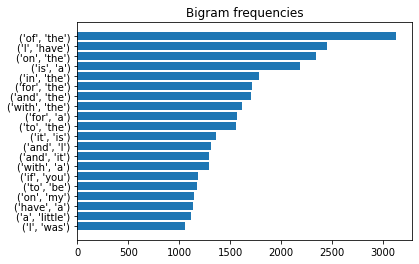

In [202]:
# Gráfico de los 20 bigramas más comunes
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')

plt.show()

In [203]:
# Los 20 trigramas más comunes
bg_freq = Counter(inst_vocabulary['trigrams'])
bg_freq_most_common = bg_freq.most_common(20)

bg_freq_most_common

[(('a', 'lot', 'of'), 458),
 (('This', 'is', 'a'), 413),
 (('this', 'is', 'a'), 322),
 (('I', 'bought', 'this'), 319),
 (('I', 'have', 'a'), 315),
 (('out', 'of', 'the'), 292),
 (('is', 'a', 'great'), 283),
 (('I', 'like', 'the'), 219),
 (('as', 'well', 'as'), 211),
 (('a', 'couple', 'of'), 201),
 (('one', 'of', 'the'), 193),
 (('if', 'you', 'are'), 192),
 (('for', 'the', 'price'), 186),
 (('I', 'had', 'to'), 184),
 (('it', 'is', 'a'), 176),
 (('looking', 'for', 'a'), 174),
 (('I', 'have', 'to'), 170),
 (('you', 'want', 'to'), 159),
 (('to', 'get', 'the'), 158),
 (('one', 'of', 'these'), 158)]

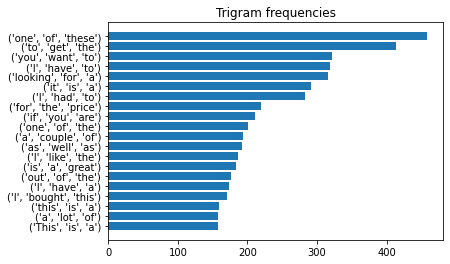

In [204]:
# Trama de los 20 trigramas más comunes
tg_freq = Counter(inst_vocabulary['trigrams'])
tg_freq_most_common = tg_freq.most_common(20)
tg_freq_most_common
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]
tgs_f_, bgs_ = zip(*sorted(zip(tgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')

plt.show()

## 5. Nubes de palabras

In [205]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    plt.show()

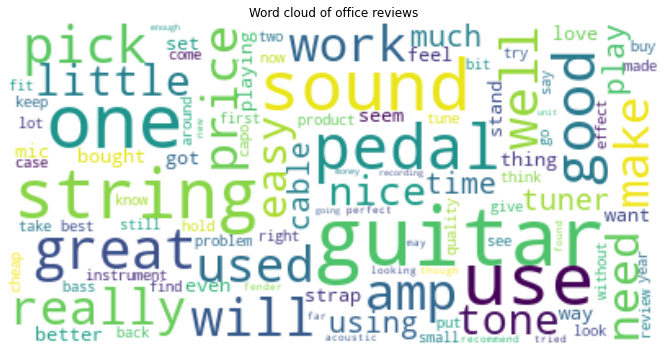

In [206]:
plot_word_cloud(' '.join(inst_vocabulary['words']).lower().strip().split(), 'Word cloud of {} reviews'.format('office'))

## 6. Visualización en 2D de algunos word embeddings

In [207]:
corpus = df_instruments['reviewText'].str.cat(sep='')
with open('corpus.txt', 'w') as text_file:
    text_file.write(corpus)

corpus = LineSentence('corpus.txt', limit=100)

corpus

In [208]:
sg_params = {
    'sg': 1,
    'vector_size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

In [209]:
# Skip Gram
w2v_sg = Word2Vec(**sg_params)
w2v_sg.build_vocab(corpus)

In [210]:
print(f"Vocabulario compuesto por {len(w2v_sg.wv)} palabras.")

Vocabulario compuesto por 9526 palabras.


In [211]:
# w2v_sg.train(sentences=corpus, total_examples=w2v_sg.corpus_count, epochs=50)

In [212]:
# Selección de palabras
keys = ['guitar', 'pedal', 'sound', 'tuner']

embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []

    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])

    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [213]:
# Reducir la dimensionalidad
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [214]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))

    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)

        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
            
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings')
    plt.show()

In [215]:
# tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

## 7. Conclusiones

> 1. Las reviews, en general, tienen una longitud inferior a 2000 caracteres.

> 2. Las palabras más comunes coinciden, en general, con las palabras más comunes del inglés ('the', 'a', 'and', 'I', ...).

> 3. Los n-grams nos ayudan a visualizar los temas de los que se hablan.

> 4. La nube de palabras nos ayuda a visualizar mejor las palabras más repetidas una vez limpio el corpus y, por consiguiente, para ver de qué se habla en el corpus.

> 5. La distribución de reviews por número de estrellas, nos muestra que, en general, los clientes están satisfechos.

In [216]:
# Como exploración adicional podemos mirar las palabras menos repetidas
wf = Counter(inst_vocabulary['words'])
wf_most_common = wf.most_common()
wf_most_common[-20:-1]

[('condom.', 1),
 ('DEVELOPED', 1),
 ('(Rosewood)', 1),
 ('&#34;bolder', 1),
 ('(Rosewood/Spruce', 1),
 ('woods)', 1),
 ('812ce', 1),
 ('12-Fret', 1),
 ('&#34;fuller', 1),
 ('Nanaweb', 1),
 ("PB's", 1),
 ('12-fret', 1),
 ('814ce', 1),
 ('difference/improvement', 1),
 ('knock,', 1),
 ('actually.The', 1),
 ('accentuates', 1),
 ('&#34;jumbo&#34;', 1),
 ('nice.Definitely', 1)]